In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [0]:
path=untar_data(URLs.MNIST)

In [3]:
URLs.MNIST

'https://s3.amazonaws.com/fast-ai-imageclas/mnist_png'

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/training'),
 PosixPath('/root/.fastai/data/mnist_png/testing')]

In [0]:
pq=ImageList.from_folder(path,convert_mode='L')

In [0]:
pq.items[1]

PosixPath('/root/.fastai/data/mnist_png/training/9/36807.png')

In [0]:
defaults.cmap='binary'

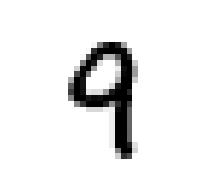

In [0]:
pq[0].show()

In [0]:
sd=pq.split_by_folder(train="training",valid="testing")

In [0]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/3')]

In [0]:
ll=sd.label_from_folder()

In [0]:
x,y=ll.train[2]

9


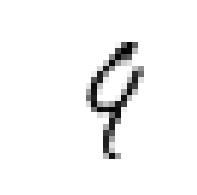

In [0]:
x.show()
print(y)

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [0]:
??rand_pad


In [0]:
ll=ll.transform(tfms)

In [0]:
bs=128

In [0]:
data=ll.databunch(bs=bs).normalize()

In [0]:
x,y = data.train_ds[0]


9


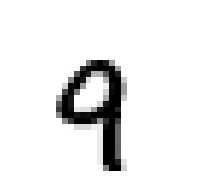

In [0]:
x.show()
print(y)

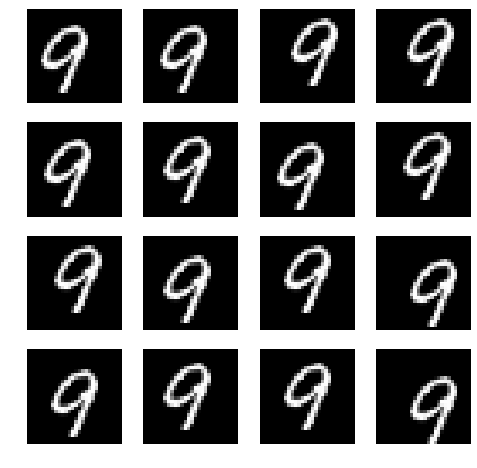

In [0]:
def _plot(i,j,ax): data.train_ds[2300][0].show(ax, cmap='gray')
plot_multi(_plot, 4, 4, figsize=(8,8))

In [0]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [0]:
on=iter(data.train_dl)

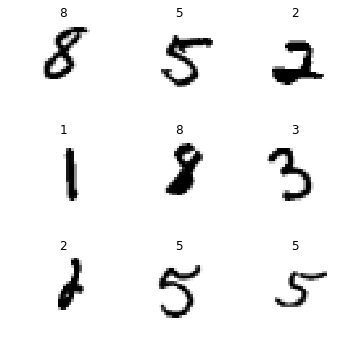

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
def conv(ni,nf): return nn.Conv2d(ni,nf,kernel_size=3,stride=2,padding=1)

In [0]:
model=nn.Sequential(
        conv(1,8),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        conv(8,16),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        conv(16,32),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        conv(32,16),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        conv(16,10),
        nn.BatchNorm2d(10),
        Flatten()
)

In [0]:
learn=Learner(data,model,loss_func=nn.CrossEntropyLoss(),metrics=accuracy)

In [0]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
______________________________________________________________

In [0]:
xb=xb.cuda()

In [0]:
model(xb).shape

torch.Size([128, 10])

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


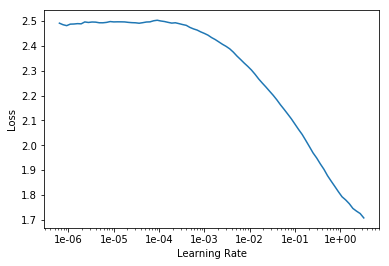

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.231959,0.197039,0.937600,00:34
1,0.131463,0.085632,0.972000,00:35
2,0.073313,0.043919,0.986700,00:35


In [0]:
??conv_layer

In [0]:
def conv2d(ni,nf): return conv_layer(ni,nf,stride=2)

In [0]:
model=nn.Sequential(
        conv2d(1,8),
        conv2d(8,16),
        conv2d(16,32),
        conv2d(32,16),
        conv2d(16,10),
        Flatten()
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [0]:
learn.fit_one_cycle(4, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.256367,0.374728,0.878600,00:34
1,0.166120,0.186931,0.938900,00:35
2,0.103508,0.051734,0.984300,00:35
3,0.067772,0.035797,0.987800,00:34


In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [0]:
??res_block()

In [0]:
??MergeLayer

In [0]:
model = nn.Sequential(
    conv2d(1, 8),
    ResBlock(8),
    conv2d(8, 16),
    ResBlock(16),
    conv2d(16, 32),
    ResBlock(32),
    conv2d(32, 16),
    ResBlock(16),
    conv2d(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


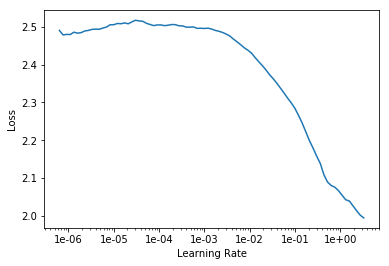

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5,max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.183473,0.535684,0.870400,00:40
1,0.114830,0.157788,0.950300,00:40
2,0.085970,0.238345,0.924000,00:41
3,0.052970,0.025537,0.991400,00:41
4,0.029057,0.019088,0.993600,00:41


In [0]:
def conv_and_res(ni,nf): return nn.Sequential(conv2d(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2d(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


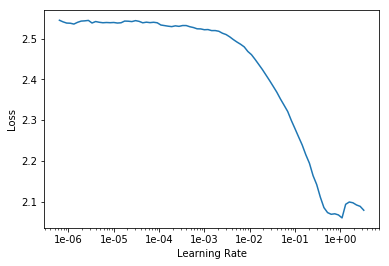

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5,0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.186020,0.139435,0.958000,00:39
1,0.110490,0.111796,0.965900,00:40
2,0.078184,0.044352,0.987300,00:40
3,0.052430,0.025094,0.992300,00:40
4,0.036358,0.019436,0.993800,00:40
